In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Store the age data in a pandas DataFrame.
data = {
    "event": ["GS-1", "GS-2.1c", "GS-2.2", "GS-3", "GS-4", "GS-5.1", "GS-5.2", "GS-6", "GS-7", "GS-8",
              "GS-9", "GS-10", "GS-11", "GS-12", "GS-13", "GS-14", "GS-15.1", "GS-15.2", "GS-16.1", "GS-16.2",
              "GS-17.1", "GS-17.2", "GS-18", "GS-19.1", "GS-19.2", "GS-20", "GS-21.1", "GS-21.2", "GS-22",
              "GS-23.1", "GS-23.2", "GS-24.1", "GS-24.2", "GS-25", "GS-26"],
    "end":   [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040, 104520, 106750, 108280, 115370],
    "start": [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380, 105440, 106900, 110640, 119140]
}

# convert data to DataFrame
df_stadial = pd.DataFrame(data)

df_pre = pd.read_csv(
    r"D:\VScode\bipolar_seesaw_CCM\inso_data\pre_long.txt", 
    sep='\s+',       # '\s+' means "split on any whitespace"
    header=None,     # or specify a row number if there's a header
    engine='python'
)


df_pre.iloc[:, 0] = df_pre.iloc[:, 0].abs() * 1000

# Rename the columns
df_pre.columns = ['age', 'pre']

# flip the data upside down
df_pre = df_pre.iloc[::-1]
df_pre = df_pre.reset_index(drop=True)
df_pre


df_obl = pd.read_csv(r"D:\VScode\bipolar_seesaw_CCM\inso_data\obl_long.txt", 
                     sep='\s+', 
                     header=None, 
                     engine='python')

df_obl.iloc[:, 0] = df_obl.iloc[:, 0].abs() * 1000

# df_obl = df_obl.iloc[::-1]
df_obl.columns = ['age', 'obl']
df_obl = df_obl.iloc[::-1]
df_obl = df_obl.reset_index(drop=True)
df_obl

,age,obl
0,0.0,0.409093
1,100.0,0.409320
2,200.0,0.409547
3,300.0,0.409773
4,400.0,0.410000
...,...,...
1396,139600.0,0.408935
1397,139700.0,0.408664
1398,139800.0,0.408393
1399,139900.0,0.408122


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def gen_stadial_percentage(df_stadial, L_win, S_step, df_pre, df_obl, if_plot=False):
    """
    Compute the stadial coverage within a sliding window (length=L_win, step=S_step)
    for the provided stadial intervals (df_stadial), and interpolate insolation data
    (precession: df_pre, obliquity: df_obl) to match the resulting time axis.
    
    Parameters
    ----------
    df_stadial : pd.DataFrame
        Must contain columns 'event', 'start', 'end'.
        'start' > 'end' in terms of "years before present" 
        (e.g., start=119140, end=11703).
    L_win : float
        Window length in years for computing stadial coverage.
    S_step : float
        Sliding step in years for computing stadial coverage.
    df_pre : pd.DataFrame
        Must contain columns ['age', 'pre']. 'age' in years before present.
        Example: read from a local file.
    df_obl : pd.DataFrame
        Must contain columns ['age', 'obl']. 'age' in years before present.
        Example: read from a local file.
    if_plot : bool
        Whether to plot intermediate checks and final time series. Defaults to False.
    
    Returns
    -------
    df_stadial_interp : pd.DataFrame
        Columns: ['age', 'stadial_percent'] on a 100-year grid.
        'age' is from 0 to ~ (max window center), going from left (0) to older times.
    df_pre_interp : pd.DataFrame
        Columns: ['age', 'pre'], interpolated on the same 100-year grid as df_stadial_interp,
        but with age running from older to younger (e.g., ~120000 down to 0).
    df_obl_interp : pd.DataFrame
        Columns: ['age', 'obl'], similarly interpolated and oriented as df_pre_interp.
    """

    # 1) Determine the overall time span of the stadial intervals.
    #    (older means larger number of years before present)
    overall_older = df_stadial["start"].max()  # e.g., 119140
    overall_recent = df_stadial["end"].min()   # e.g., 11703
    
    # 2) Prepare sliding windows from older to recent, stepping backward in time.
    #    We go from overall_older down to overall_recent, in steps of S_step
    #    but ensure the window is wide enough to include the last portion:
    w_old_values = np.arange(overall_older, overall_recent + L_win - 1, -S_step)
    
    window_centers = []
    stadial_percentages = []
    
    # 3) For each sliding window, compute stadial coverage
    for w_old in w_old_values:
        w_recent = w_old - L_win  # younger boundary
        # midpoint of the window (for storing in 'window_centers')
        win_center = w_old - (L_win / 2.0)
        
        total_overlap = 0.0
        
        # Accumulate the overlap between each stadial event and the current window
        for idx, row in df_stadial.iterrows():
            # An event is [event_end, event_start] in "years before present"
            event_end = row["end"]
            event_start = row["start"]
            
            # Overlap with the window [w_recent, w_old]
            overlap = max(0.0, min(w_old, event_start) - max(w_recent, event_end))
            total_overlap += overlap
        
        # Compute the fraction (in %) of L_win that is stadial coverage
        pct = (total_overlap / L_win) * 100.0
        window_centers.append(win_center)
        stadial_percentages.append(pct)
    
    # Convert to numpy arrays for sorting and interpolation
    window_centers = np.array(window_centers)
    stadial_percentages = np.array(stadial_percentages)
    
    # If requested, plot the raw (unsorted) coverage vs. window_centers
    if if_plot:
        plt.figure()
        plt.plot(window_centers, stadial_percentages, marker='', linestyle='-')
        plt.xlabel("Years before present (window center)")
        plt.ylabel("Stadial Coverage (%)")
        plt.title("Raw Stadial Coverage in Sliding Windows")
        # plt.grid(True)
        plt.show()

    
    # 4) Sort by ascending time (from most recent to oldest is typical, but let's unify):
    #    Actually, the next code sorts from smallest to largest "window_centers" for interpolation
    sort_idx = np.argsort(window_centers)
    x_sorted = window_centers[sort_idx]
    y_sorted = stadial_percentages[sort_idx]
    
    # Build a new time axis at 100-year resolution
    # from the minimum to the maximum of x_sorted
    x_min = x_sorted[0]
    x_max = x_sorted[-1]
    new_x = np.arange(x_min, x_max + 1, 100)
    
    # Perform linear interpolation for stadial coverage
    new_y = np.interp(new_x, x_sorted, y_sorted)
    
    # 5) Flip new_x so that it runs from 0 to ~max_age (left to right = younger to older in final code)
    #    This is the same logic as in the user's code:
    new_x = (new_x - new_x.max()) * -1.0
    new_x = np.abs(new_x)
    
    # If requested, plot the interpolated coverage
    if if_plot:
        plt.figure()
        plt.plot(new_x, new_y, marker='', linestyle='-')
        plt.xlabel("Years before present (window center)")
        plt.ylabel("Stadial Coverage (%)")
        plt.title("Interpolated Stadial Coverage (100-yr spacing)")
        # plt.grid(True)
        plt.show()
    
    # We now have stadial coverage in (new_x, new_y), where new_x runs from 0 up to ~max_age
    # Let's define the final DataFrame for stadial coverage
    df_stadial_interp = pd.DataFrame({
        "age": new_x,
        "stadial_percent": new_y
    })
    
    # 6) Crop and interpolate the pre and obl data to match the same overall time range
    age_start = new_x.min()
    age_end = new_x.max()
    
    # We'll define a new regular axis from age_start to age_end in 100-yr steps
    new_age = np.arange(age_start, age_end + 1, 100)
    
    # Interpolate pre to new_age
    # Note: df_pre['age'] is in years before present. We'll just do a direct interpolation.
    pre_interp = np.interp(new_age, df_pre['age'], df_pre['pre'])
    df_pre_interp = pd.DataFrame({'age': new_age, 'pre': pre_interp})
    
    # Interpolate obl to new_age
    obl_interp = np.interp(new_age, df_obl['age'], df_obl['obl'])
    df_obl_interp = pd.DataFrame({'age': new_age, 'obl': obl_interp})
    
    # Finally, to replicate the user's final flipping so that we get older->younger for the insolation data:
    # new_age 0 => becomes age_end, new_age age_end => becomes 0
    # i.e. age_new = -1 * new_age + age_end
    df_pre_interp['age'] = df_pre_interp['age'] * -1.0 + age_end
    df_obl_interp['age'] = df_obl_interp['age'] * -1.0 + age_end
    
    if if_plot:
        # Plot the final Pre data
        plt.figure()
        plt.plot(df_pre_interp['age'], df_pre_interp['pre'], linestyle='-')
        plt.xlabel('Age (transformed)')
        plt.ylabel('pre')
        plt.title('Interpolated Precession vs. Age')
        plt.grid(True)
        plt.show()
        
        # Plot the final Obl data
        plt.figure()
        plt.plot(df_obl_interp['age'], df_obl_interp['obl'], linestyle='-')
        plt.xlabel('Age (transformed)')
        plt.ylabel('obl')
        plt.title('Interpolated Obliquity vs. Age')
        plt.grid(True)
        plt.show()
    
    return df_stadial_interp, df_pre_interp, df_obl_interp


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def find_optimal_L_win(
    df_stadial,     # DataFrame or dict for stadial intervals (compatible with gen_stadial_percentage)
    df_pre,         # DataFrame: columns = ['age','pre']
    df_obl,         # DataFrame: columns = ['age','obl']
    gen_stadial_percentage_func,  # your function handle e.g. gen_stadial_percentage
    ccm_func,       # your CCM function handle, e.g. cf.ccm_DOXmapForcing
    target="pre",   # SWITCH: choose "pre" or "obl" as the CCM target
    E=4,
    tau=8,
    libSizes="100 200 300 400 500 600 700",
    Tp=0,
    sample=20
):
    """
    Loop L_win from 6000 to 40000 (step=2000), compute stadial coverage time series,
    then perform CCM to see how well stadial coverage can predict either 'pre' or 'obl'
    (depending on the 'target' parameter). Plots the maximum cross mapping skill (rho)
    as a function of L_win.

    Parameters
    ----------
    df_stadial : pd.DataFrame or dict
        Contains the stadial information. Must be compatible with the 
        gen_stadial_percentage() function. For instance, if using a dict:
            {
                "event": [...],
                "end": [...],
                "start": [...]
            }
    df_pre : pd.DataFrame
        Columns = ['age', 'pre']
    df_obl : pd.DataFrame
        Columns = ['age', 'obl']
    gen_stadial_percentage_func : function
        Your function that accepts (df_stadial, L_win, S_step, df_pre, df_obl, if_plot=False)
        and returns (df_stadial_interp, df_pre_interp, df_obl_interp).
    ccm_func : function
        Your CCM function, e.g. ccm_DOXmapForcing(df_sd=..., df_pre=..., E=..., tau=..., ...)
    target : str
        Either "pre" or "obl". This determines which insolation variable we attempt to
        predict from the stadial coverage.
    E, tau, libSizes, Tp, sample : 
        Parameters passed to the CCM function.

    Returns
    -------
    L_win_values : list
        The list of L_win values tested.
    max_rho_list : list
        The list of maximum CCM skill for "stadial coverage -> target" found at each L_win.
    """

    if target not in ["pre", "obl"]:
        raise ValueError("`target` must be either 'pre' or 'obl'.")

    L_win_values = range(6000, 40001, 2000)  # 6000 to 40000 by 2000
    max_rho_list = []

    for L_win in L_win_values:
        # 1. Generate the stadial coverage time series for this window size.
        df_stadial_interp, df_pre_interp, df_obl_interp = gen_stadial_percentage_func(
            df_stadial,
            L_win=L_win,
            S_step=100,   # You may change S_step if desired
            df_pre=df_pre,
            df_obl=df_obl,
            if_plot=False # set True if you want to see intermediate plots
        )

        # 2. Choose which DataFrame (df_pre_interp or df_obl_interp) is the target for CCM
        if target == "pre":
            df_target = df_pre_interp  # We'll predict pre from stadial coverage
        else:
            df_target = df_obl_interp  # We'll predict obl from stadial coverage

        # 3. Perform CCM: stadial coverage -> chosen target (pre or obl)
        ccm_out = ccm_func(
            df_sd    = df_stadial_interp,
            df_pre   = df_target,  # ccm_DOXmapForcing expects 'df_pre', but it can be 'obl' data if we rename
            E        = E,
            tau      = tau,
            libSizes = libSizes,
            Tp       = Tp,
            sample   = sample,
            showPlot = False  # turn on if you want to see each CCM skill plot
        )

        # 4. Identify the column names for forward cross mapping
        stadial_column_name = df_stadial_interp.columns[1]  # e.g. "stadial_percent"
        target_column_name  = df_target.columns[1]          # e.g. "pre" or "obl"
        forward_key         = f"{stadial_column_name}:{target_column_name}"

        # 5. Find the maximum cross-mapping skill for "stadial coverage -> target"
        if forward_key not in ccm_out.columns:
            raise ValueError(
                f"Expected '{forward_key}' in CCM output, but found columns: {ccm_out.columns}"
            )
        max_rho = ccm_out[forward_key].max()
        max_rho_list.append(max_rho)

    # 6. Plot how the maximum rho changes with L_win
    plt.figure()
    plt.plot(L_win_values, max_rho_list, marker='o', linestyle='-')
    plt.xlabel("L_win (years)")
    plt.ylabel(f"Max CCM skill (rho) for stadial -> {target}")
    plt.title(f"Max CCM skill vs. L_win (stadial -> {target})")
    plt.grid(True)
    plt.show()

    return list(L_win_values), max_rho_list


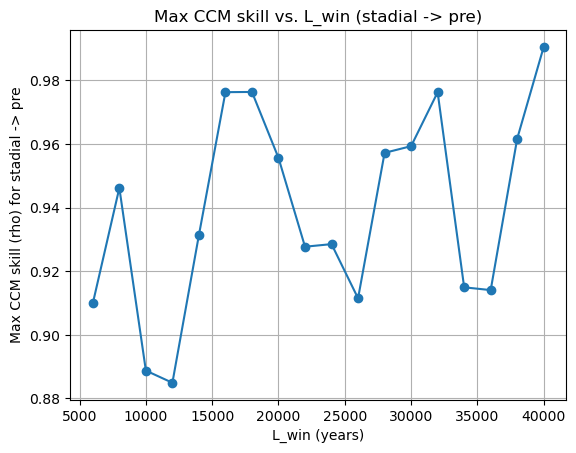

In [31]:
from toolbox import ccm_functions as cf
import importlib
importlib.reload(cf)

# Now call the testing function
L_win_values, max_rho_list = find_optimal_L_win(
    df_stadial=df_stadial, 
    df_pre=df_pre, 
    df_obl=df_obl,
    gen_stadial_percentage_func=gen_stadial_percentage,  # your function
    ccm_func=cf.ccm_DOXmapForcing,
    target="pre",
    E=4,
    tau=8,
    libSizes="100 200 300 400 500 600",
    Tp=0,
    sample=20
)


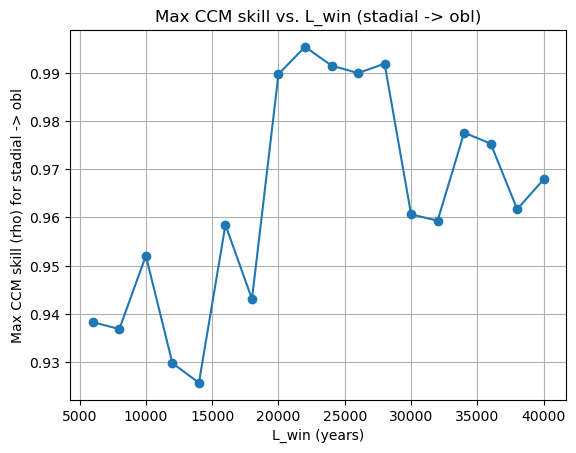

In [32]:
from toolbox import ccm_functions as cf
import importlib
importlib.reload(cf)

# Now call the testing function
L_win_values, max_rho_list = find_optimal_L_win(
    df_stadial=df_stadial, 
    df_pre=df_pre, 
    df_obl=df_obl,
    gen_stadial_percentage_func=gen_stadial_percentage,  # your function
    ccm_func=cf.ccm_DOXmapForcing,
    target="obl",
    E=4,
    tau=8,
    libSizes="100 200 300 400 500 600",
    Tp=0,
    sample=20
)

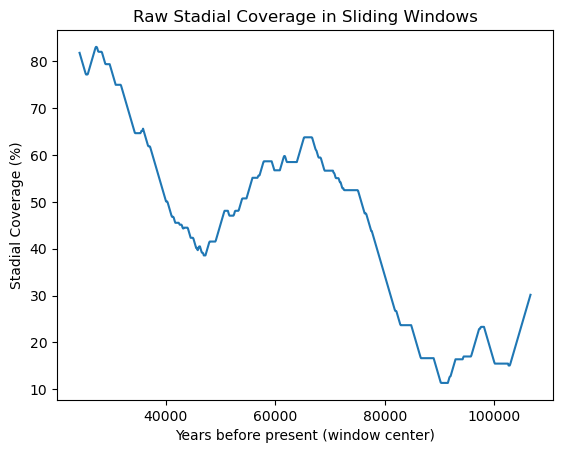

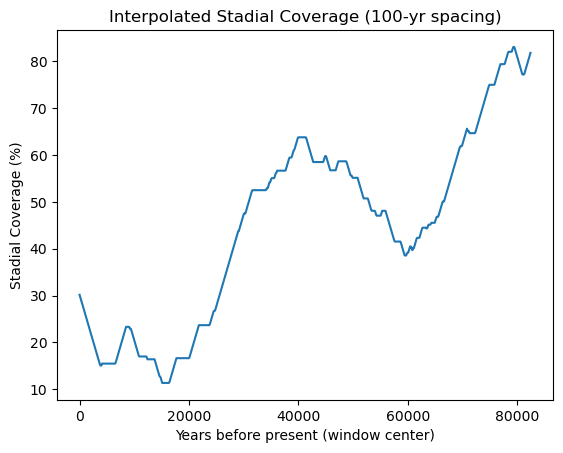

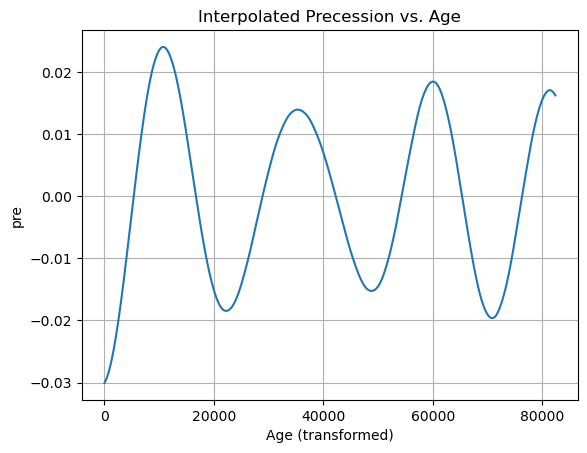

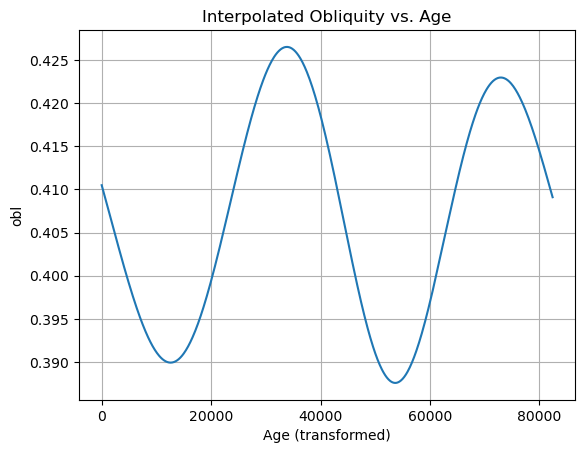

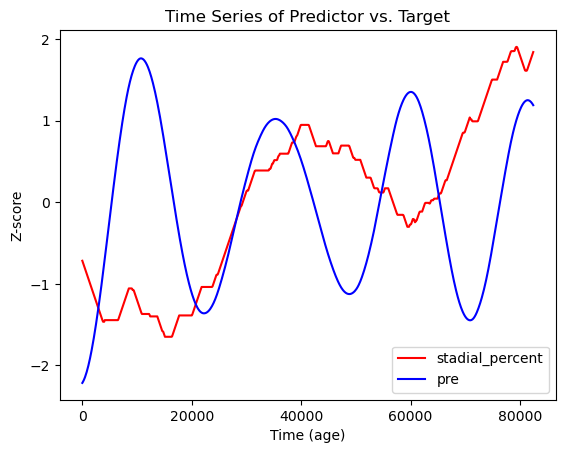

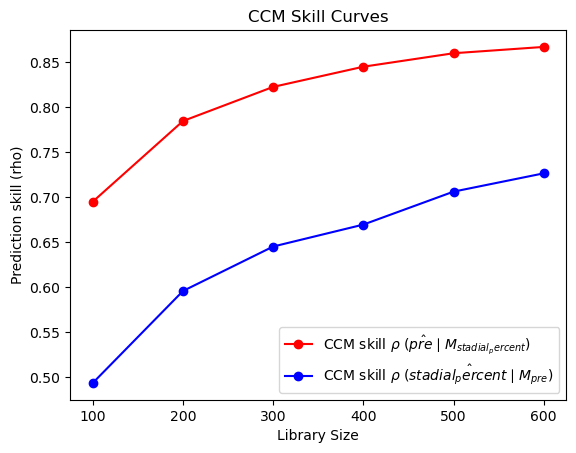

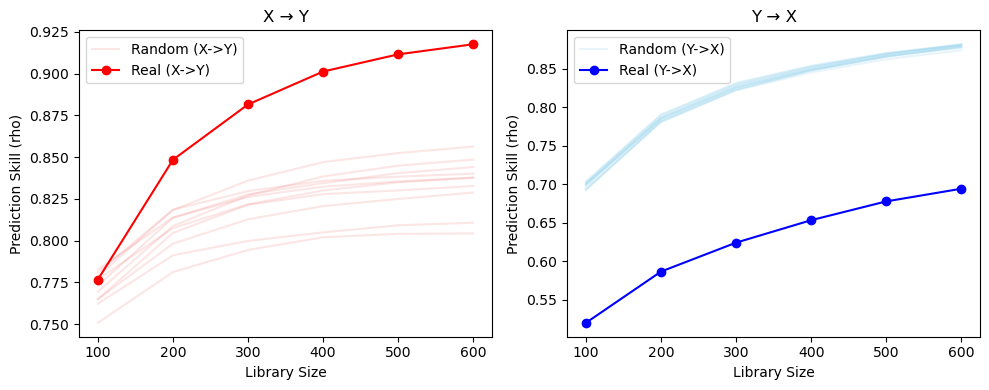

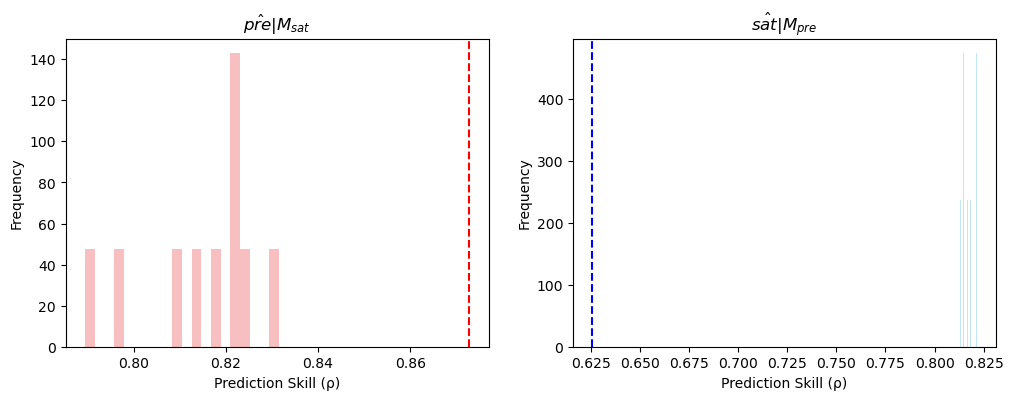

True


In [39]:
df_stadial_interp, df_pre_interp, df_obl_interp = gen_stadial_percentage(
    df_stadial, 25000, 100, df_pre, df_obl, if_plot=True
)


from toolbox import ccm_functions as cf
import importlib
importlib.reload(cf)


result = cf.ccm_DOXmapForcing(
    df_sd      = df_stadial_interp,
    df_pre     = df_pre_interp,
    E          = 4,
    tau        = 8,
    libSizes   = "100 200 300 400 500 600",
    Tp=0,
    sample     = 20,
    showPlot   = True
)

from toolbox import significant_test as st
import importlib
importlib.reload(st)

ccm_out, ran_ccm_list = st.ccm_significance_statistic(
    df_sd      = df_stadial_interp,
    df_pre     = df_pre_interp,
    E         = 4,
    tau       = 11,
    fraction  = 0.1,
    n_ran     = 10,
    libSizes  = "100 200 300 400 500 600",
    sample    = 100,
    showPlot  = True
)

test_result = st.ccm_significance_test(ccm_out, ran_ccm_list, if_plot=True)
print(test_result)


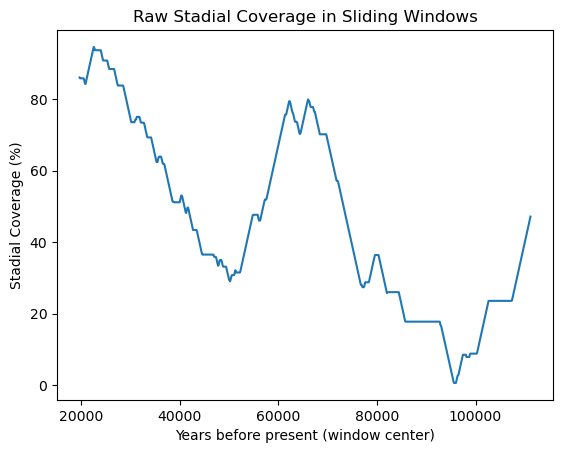

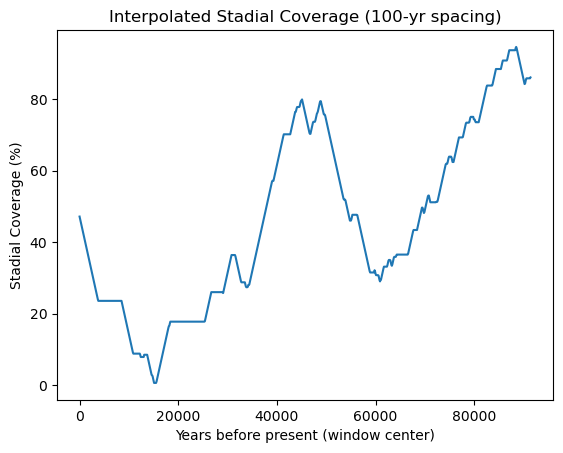

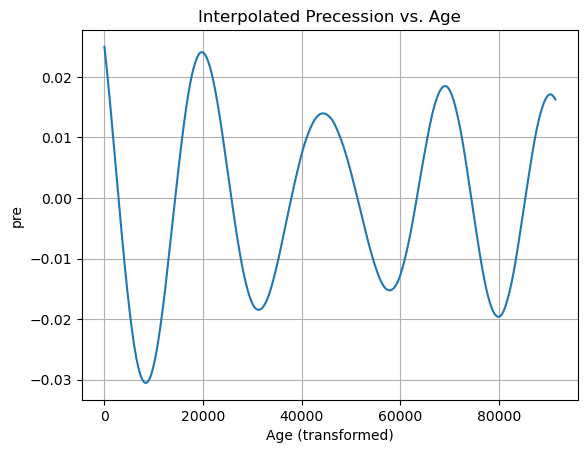

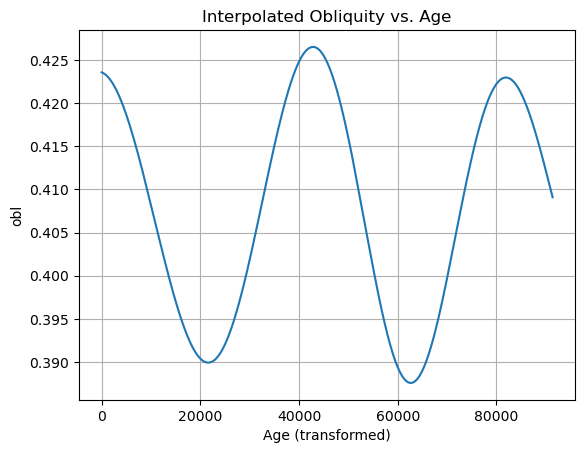

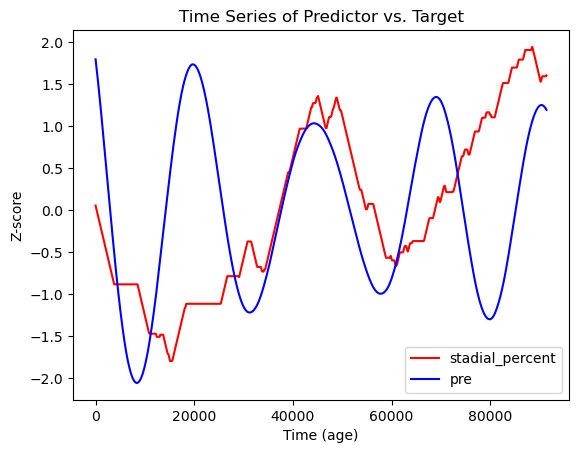

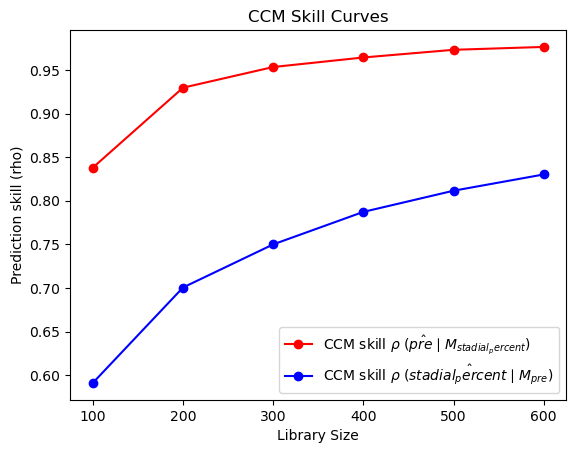

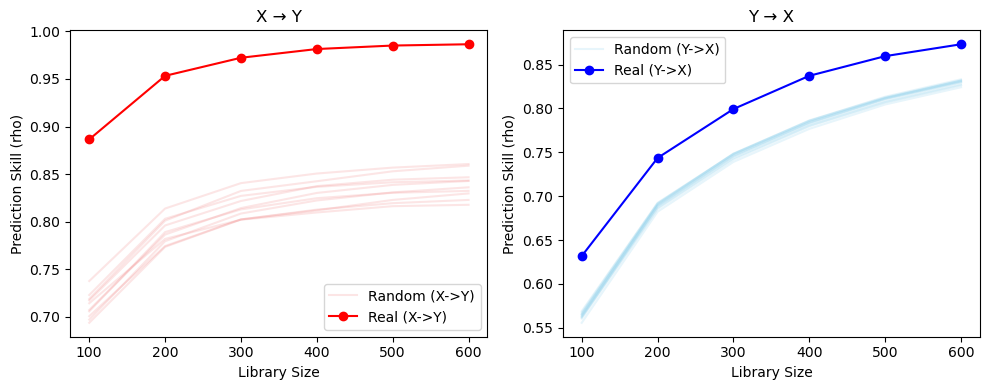

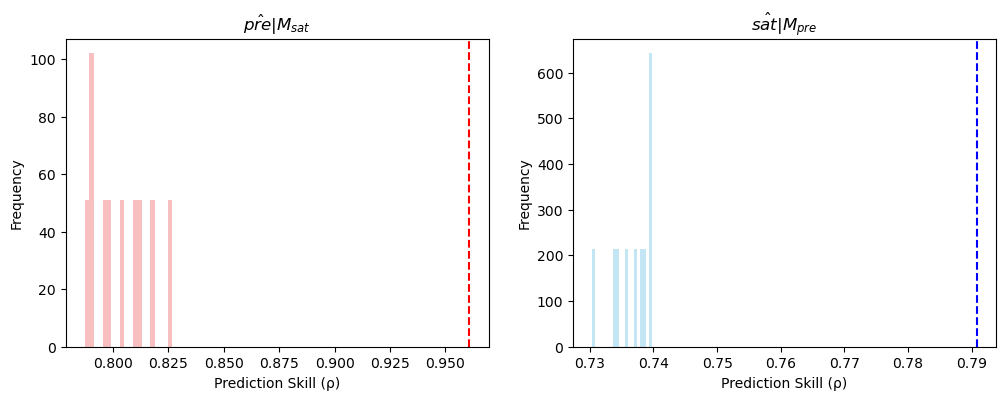

False


In [38]:
df_stadial_interp, df_pre_interp, df_obl_interp = gen_stadial_percentage(
    df_stadial, 16000, 100, df_pre, df_obl, if_plot=True
)


from toolbox import ccm_functions as cf
import importlib
importlib.reload(cf)


result = cf.ccm_DOXmapForcing(
    df_sd      = df_stadial_interp,
    df_pre     = df_pre_interp,
    E          = 4,
    tau        = 8,
    libSizes   = "100 200 300 400 500 600",
    Tp=0,
    sample     = 20,
    showPlot   = True
)

from toolbox import significant_test as st
import importlib
importlib.reload(st)

ccm_out, ran_ccm_list = st.ccm_significance_statistic(
    df_sd      = df_stadial_interp,
    df_pre     = df_pre_interp,
    E         = 4,
    tau       = 11,
    fraction  = 0.1,
    n_ran     = 10,
    libSizes  = "100 200 300 400 500 600",
    sample    = 100,
    showPlot  = True
)

test_result = st.ccm_significance_test(ccm_out, ran_ccm_list, if_plot=True)
print(test_result)


# Test for obl

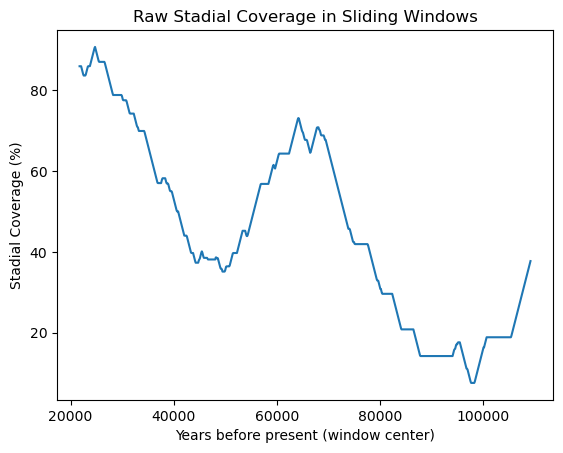

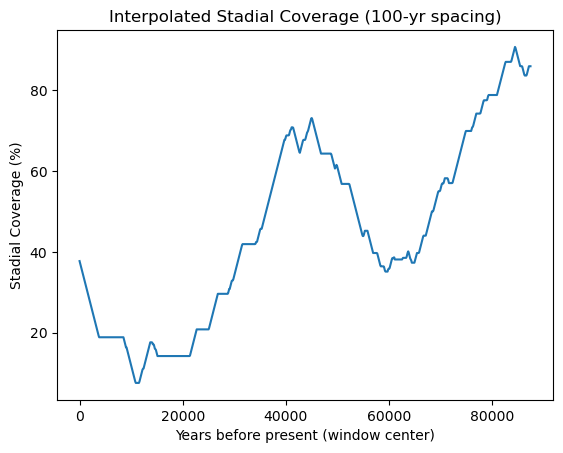

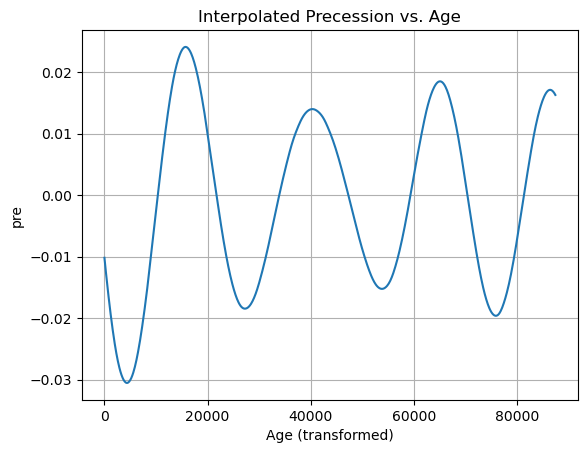

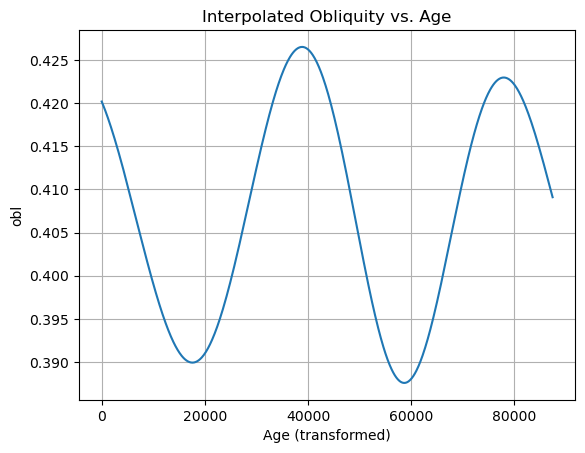

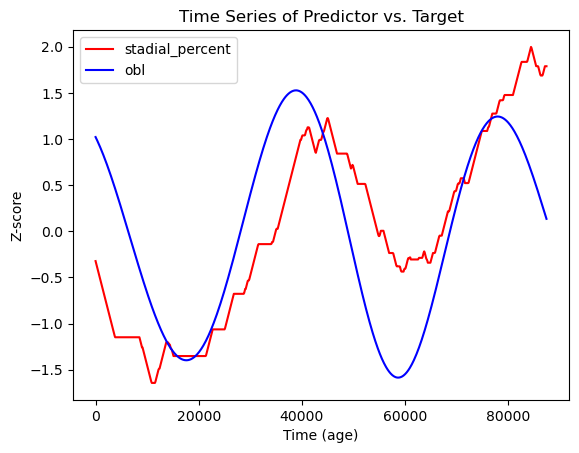

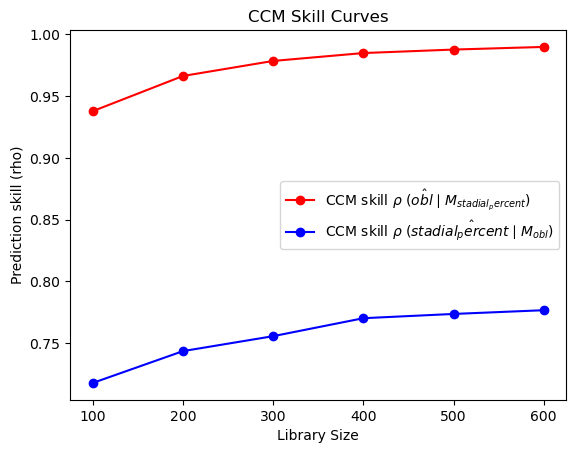

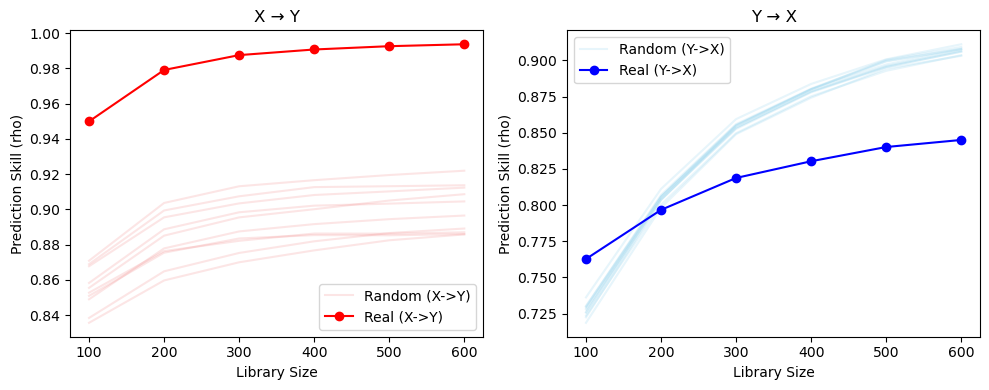

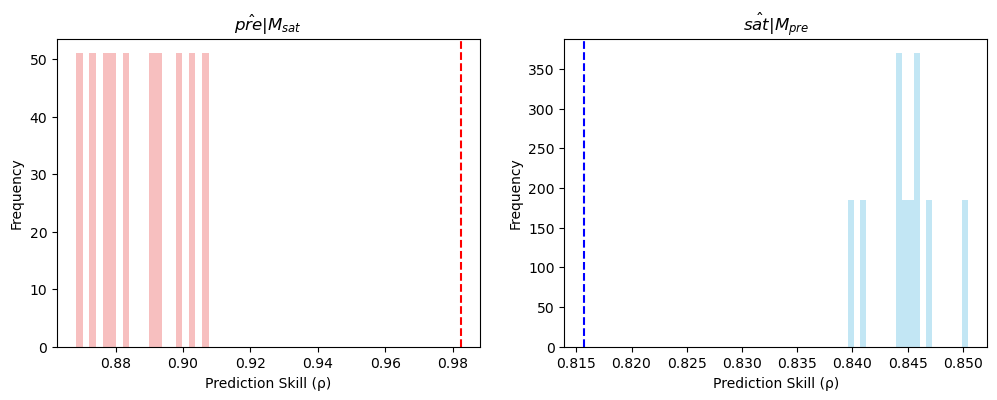

True


In [40]:
df_stadial_interp, df_pre_interp, df_obl_interp = gen_stadial_percentage(
    df_stadial, 20000, 100, df_pre, df_obl, if_plot=True
)


from toolbox import ccm_functions as cf
import importlib
importlib.reload(cf)


result = cf.ccm_DOXmapForcing(
    df_sd      = df_stadial_interp,
    df_pre     = df_obl_interp,
    E          = 4,
    tau        = 8,
    libSizes   = "100 200 300 400 500 600",
    Tp=0,
    sample     = 20,
    showPlot   = True
)

from toolbox import significant_test as st
import importlib
importlib.reload(st)

ccm_out, ran_ccm_list = st.ccm_significance_statistic(
    df_sd      = df_stadial_interp,
    df_pre     = df_obl_interp,
    E         = 4,
    tau       = 11,
    fraction  = 0.1,
    n_ran     = 10,
    libSizes  = "100 200 300 400 500 600",
    sample    = 100,
    showPlot  = True
)

test_result = st.ccm_significance_test(ccm_out, ran_ccm_list, if_plot=True)
print(test_result)


In [25]:
result

,LibSize,stadial_percent:pre,pre:stadial_percent
0,100.0,0.740212,0.629763
1,200.0,0.836142,0.746113
2,300.0,0.870789,0.804738
3,400.0,0.895585,0.838681
4,500.0,0.908011,0.856636
5,600.0,0.918759,0.868813
6,700.0,0.927928,0.880936


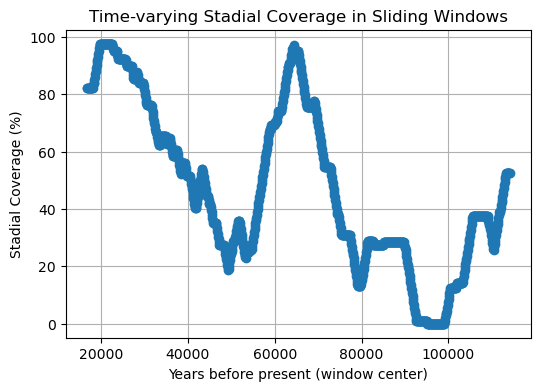

Max window center:  114140.0
Min window center:  16740.0
Number of events:  35
Max x_sorted:  114140.0
Min x_sorted:  16740.0


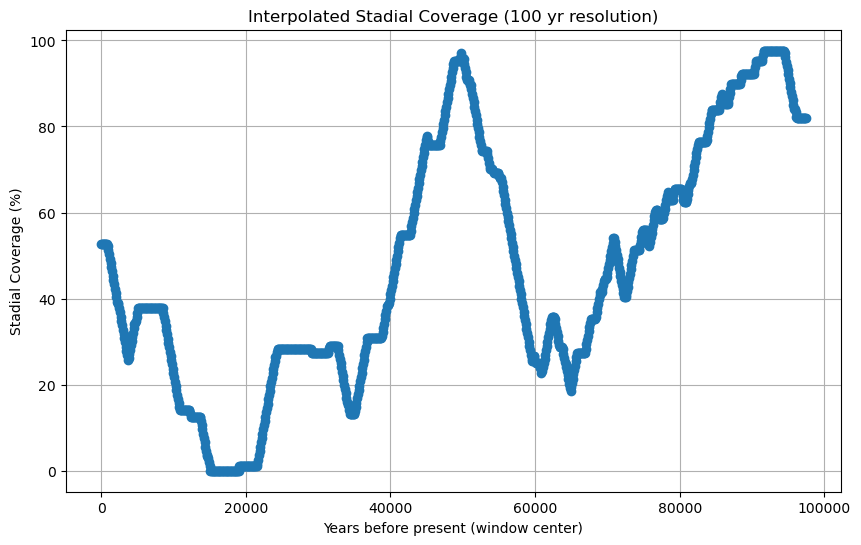

Max of new_x:  97400.0
Min of new_x:  0.0
Length of new_x:  975
new_age max: 97400.0
new_age min: 0.0
new_age length: 975


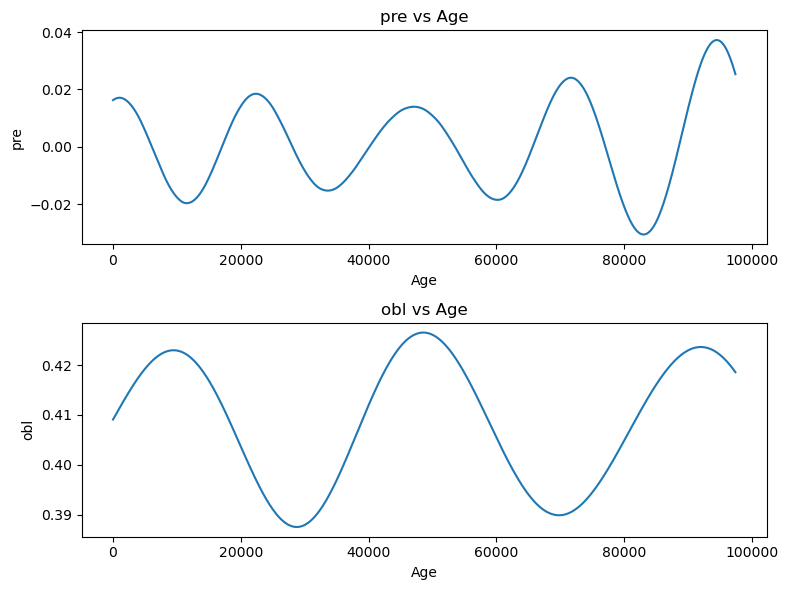

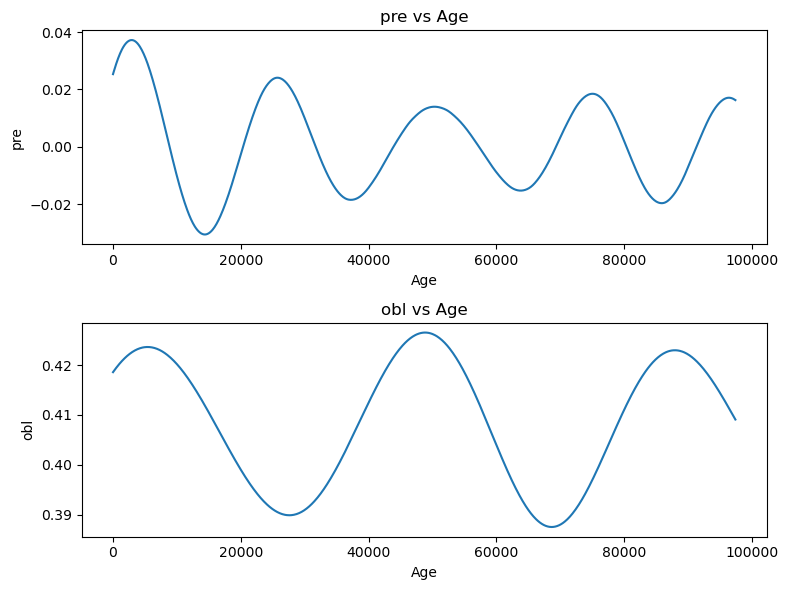

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Store the age data in a pandas DataFrame.
data = {
    "event": ["GS-1", "GS-2.1c", "GS-2.2", "GS-3", "GS-4", "GS-5.1", "GS-5.2", "GS-6", "GS-7", "GS-8",
              "GS-9", "GS-10", "GS-11", "GS-12", "GS-13", "GS-14", "GS-15.1", "GS-15.2", "GS-16.1", "GS-16.2",
              "GS-17.1", "GS-17.2", "GS-18", "GS-19.1", "GS-19.2", "GS-20", "GS-21.1", "GS-21.2", "GS-22",
              "GS-23.1", "GS-23.2", "GS-24.1", "GS-24.2", "GS-25", "GS-26"],
    "end":   [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040, 104520, 106750, 108280, 115370],
    "start": [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380, 105440, 106900, 110640, 119140]
}

df = pd.DataFrame(data)

# 2. Set the sliding window parameters.
L_win = 10000  # window length in years
S_step = 100  # sliding step in years

# Determine the overall time span of the stadial events.
overall_older = df["start"].max()    # oldest, e.g., 119140 years before present
overall_recent = df["end"].min()       # most recent, e.g., 11703 years before present


w_old_values = np.arange(overall_older, overall_recent + L_win - 1, -S_step)

# Prepare lists to store the window centers and the stadial percentage.
window_centers = []
stadial_percentages = []

# For each sliding window, calculate the total overlapping duration.
for w_old in w_old_values:
    w_recent = w_old - L_win  # the younger boundary of the window
    # Compute the window center (for plotting)
    win_center = w_old - L_win / 2
    
    total_overlap = 0.0
    # For each stadial event, compute the overlap with the current window.
    for idx, row in df.iterrows():
        # Event interval is [event_end, event_start]
        event_end = row["end"]
        event_start = row["start"]
        # Calculate overlap: 
        overlap = max(0, min(w_old, event_start) - max(w_recent, event_end))
        total_overlap += overlap
        
    # Percentage of the window covered by stadials:
    pct = (total_overlap / L_win) * 100
    window_centers.append(win_center)
    stadial_percentages.append(pct)

# 3. Plot the time series of the stadial percentage.
plt.figure(figsize=(6, 4))
plt.plot(window_centers, stadial_percentages, marker='o', linestyle='-')
plt.xlabel("Years before present (window center)")
plt.ylabel("Stadial Coverage (%)")
plt.title("Time-varying Stadial Coverage in Sliding Windows")
plt.grid(True)
# Invert the x-axis so that older times (larger values) appear on the left.
# plt.gca().invert_xaxis()
plt.show()

# print max window center 
print("Max window center: ", max(window_centers))
print("Min window center: ", min(window_centers))

# print the number of 'event'
print("Number of events: ", len(data["event"]))



import numpy as np
import matplotlib.pyplot as plt


# Convert lists to numpy arrays
window_centers = np.array(window_centers)
stadial_percentages = np.array(stadial_percentages)

# For interpolation, sort the data in ascending order (from most recent to oldest)
sort_idx = np.argsort(window_centers)
x_sorted = window_centers[sort_idx]
y_sorted = stadial_percentages[sort_idx]

# Create a new time axis with 100-year resolution.
# new_x will range from the minimum to the maximum window center (in years before present)
new_x = np.arange(x_sorted[0], x_sorted[-1] + 1, 100)

# print max x_sorted
print("Max x_sorted: ", max(x_sorted))
print("Min x_sorted: ", min(x_sorted))



# Perform linear interpolation to get the new y values.
new_y = np.interp(new_x, x_sorted, y_sorted)

new_x=(new_x-max(new_x))*-1
new_x=abs(new_x)

# Plot the interpolated time series.
plt.figure(figsize=(10, 6))
plt.plot(new_x, new_y, marker='o', linestyle='-')
plt.xlabel("Years before present (window center)")
plt.ylabel("Stadial Coverage (%)")
plt.title("Interpolated Stadial Coverage (100 yr resolution)")
plt.grid(True)
# Invert the x-axis so that older times (larger values) appear on the left.
# plt.gca().invert_xaxis()
plt.show()

# print the max and min of the new_x
print("Max of new_x: ", max(new_x))
print("Min of new_x: ", min(new_x))
# print the length of new_x
print("Length of new_x: ", len(new_x))





# process the long precession data
import pandas as pd
import numpy as np

# Read the file into a DataFrame
df_pre = pd.read_csv(
    r"D:\VScode\bipolar_seesaw_CCM\inso_data\pre_long.txt", 
    sep='\s+',       # '\s+' means "split on any whitespace"
    header=None,     # or specify a row number if there's a header
    engine='python'
)


df_pre.iloc[:, 0] = df_pre.iloc[:, 0].abs() * 1000

# Rename the columns
df_pre.columns = ['age', 'pre']

# flip the data upside down
df_pre = df_pre.iloc[::-1]
df_pre = df_pre.reset_index(drop=True)
df_pre


df_obl = pd.read_csv(r"D:\VScode\bipolar_seesaw_CCM\inso_data\obl_long.txt", 
                     sep='\s+', 
                     header=None, 
                     engine='python')

df_obl.iloc[:, 0] = df_obl.iloc[:, 0].abs() * 1000

# df_obl = df_obl.iloc[::-1]
df_obl.columns = ['age', 'obl']
df_obl = df_obl.iloc[::-1]
df_obl = df_obl.reset_index(drop=True)
df_obl

age_start = min(new_x)
step=100
age_end = max(new_x)


# Create a new time from age_start to age_end step=100
new_age = np.arange(age_start, age_end+1, 100)

# 1) Interpolate pre to new_age
pre_interp = np.interp(new_age, df_pre['age'], df_pre['pre'])
df_pre_interp = pd.DataFrame({'age': new_age, 'pre': pre_interp})

# 2) Interpolate obl to new_age
obl_interp = np.interp(new_age, df_obl['age'], df_obl['obl'])
df_obl_interp = pd.DataFrame({'age': new_age, 'obl': obl_interp})

# prin the max and min of the new_age
print('new_age max:', new_age.max())
print('new_age min:', new_age.min())
# print the length of new_age
print('new_age length:', len(new_age))




import pandas as pd
import matplotlib.pyplot as plt


# -- Plotting in a 2x1 figure --
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

# Upper subplot: pre
ax1.plot(df_pre_interp['age'], df_pre_interp['pre'])
ax1.set_title('pre vs Age')
ax1.set_xlabel('Age')
ax1.set_ylabel('pre')

# Lower subplot: obl
ax2.plot(df_obl_interp['age'], df_obl_interp['obl'])
ax2.set_title('obl vs Age')
ax2.set_xlabel('Age')
ax2.set_ylabel('obl')

plt.tight_layout()
plt.show()




df_pre_interp['age'] = df_pre_interp['age']*-1  +age_end
df_obl_interp['age'] = df_obl_interp['age'] *-1 + age_end

import pandas as pd
import matplotlib.pyplot as plt


# -- Plotting in a 2x1 figure --
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

# Upper subplot: pre
ax1.plot(df_pre_interp['age'], df_pre_interp['pre'])
ax1.set_title('pre vs Age')
ax1.set_xlabel('Age')
ax1.set_ylabel('pre')

# Lower subplot: obl
ax2.plot(df_obl_interp['age'], df_obl_interp['obl'])
ax2.set_title('obl vs Age')
ax2.set_xlabel('Age')
ax2.set_ylabel('obl')

plt.tight_layout()
plt.show()



